<a href="https://colab.research.google.com/github/Shivam-Miglani/easdrl_datasets/blob/main/ceasdrl_act_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Shivam-Miglani/easdrl_datasets.git

Cloning into 'easdrl_datasets'...
remote: Enumerating objects: 327, done.
remote: Total 327 (delta 0), reused 0 (delta 0), pack-reused 327
Receiving objects: 100% (327/327), 2.55 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
!pip install ipymarkup

In [40]:
!pip install flair

  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
gym 0.25.1 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from flair.embeddings import (
    WordEmbeddings,
    StackedEmbeddings,
    TransformerWordEmbeddings,
)
from flair.data import Sentence
import torch
from tqdm.notebook import tqdm
tqdm.pandas()

In [25]:
CL = 512
D = 868

In [76]:
fp = 'easdrl_datasets/win2k_act.pkl'
df = pd.DataFrame(pd.read_pickle(fp))
df = df.rename(columns = {"words": "tokens"})
del df['sent_acts']
del df['word2sent']
df.head()

,tokens,acts,sents
0,"[Click, start, point, to, settings, and, then,...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...","[[Click, start, point, to, settings, and, then..."
1,"[Click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...","[[Click, start, point, to, settings, click, co..."
2,"[Click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...","[[Click, start, point, to, settings, click, co..."
3,"[Click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...","[[Click, start, point, to, settings, click, co..."
4,"[Right-Click, the, internet, explorer, icon, o...","[{'act_idx': 0, 'obj_idxs': [[2, 3, 4], []], '...","[[Right-Click, the, internet, explorer, icon, ..."


In [77]:
# df['sents_'] = df.sents.apply(lambda x: [' '.join(y).lower() for y in x])
# df['docs'] = df.sents_.apply(lambda x: '\n'.join(x))
df['tokens'] = df.tokens.apply(lambda x: [y.lower() for y in x])
df['sents'] = df.sents.apply(lambda x: [' '.join(y).lower() for y in x])
df['act_idxs'] = df.acts.apply(lambda x: [y['act_idx'] for y in x])
df['act_types'] = df.acts.apply(lambda x: [y['act_type'] + 1 for y in x])
df['doc_len'] = df.tokens.apply(lambda x: len(x))
# df['pad_len'] = df.doc_len.apply(lambda x : CL - x if (CL - x) > 0 else 0)
df.head()

,tokens,acts,sents,act_idxs,act_types,doc_len
0,"[click, start, point, to, settings, and, then,...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings and then click ...,"[0, 2, 7, 14, 21]","[2, 2, 2, 2, 2]",24
1,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 19, 21, 32, 36]","[2, 2, 2, 2, 3, 2, 2, 2]",38
2,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 16]","[2, 2, 2, 2, 2]",19
3,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 12, 17, 29, 31, 33, 43, 47]","[2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]",49
4,"[right-click, the, internet, explorer, icon, o...","[{'act_idx': 0, 'obj_idxs': [[2, 3, 4], []], '...",[right-click the internet explorer icon on you...,"[0, 10, 16, 22, 25, 38]","[2, 2, 2, 2, 2, 2]",40


In [28]:
# delete one larger than 512 words document 
if fp == 'easdrl_datasets/wikihow_act.pkl':
  df = df.drop(100).reset_index(drop=True)

In [78]:
df.shape

(154, 6)

In [79]:
# 1: REJECT 2: ES, 3: OPT, 4: EX
def get_tags(row):
  ais = row.act_idxs
  act_types = row.act_types
  tags = np.ones([512,1])
  for i, ai in enumerate(ais):
    tags[ai] = act_types[i]
  return tags
df['tags'] = df.apply(get_tags, axis=1)
df.head()

,tokens,acts,sents,act_idxs,act_types,doc_len,tags
0,"[click, start, point, to, settings, and, then,...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings and then click ...,"[0, 2, 7, 14, 21]","[2, 2, 2, 2, 2]",24,"[[2.0], [1.0], [2.0], [1.0], [1.0], [1.0], [1...."
1,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 19, 21, 32, 36]","[2, 2, 2, 2, 3, 2, 2, 2]",38,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1...."
2,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 16]","[2, 2, 2, 2, 2]",19,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1...."
3,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 12, 17, 29, 31, 33, 43, 47]","[2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]",49,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1...."
4,"[right-click, the, internet, explorer, icon, o...","[{'act_idx': 0, 'obj_idxs': [[2, 3, 4], []], '...",[right-click the internet explorer icon on you...,"[0, 10, 16, 22, 25, 38]","[2, 2, 2, 2, 2, 2]",40,"[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [80]:
def get_emb(emb_name, mean=False):
    def get_s_emb(emb_name):
        return StackedEmbeddings(
            [
                WordEmbeddings("glove"),
                TransformerWordEmbeddings(
                    emb_name,
                    layers="all",
                    subtoken_pooling="mean",
                    layer_mean=mean,
                    use_context=True,
                ),
            ]
        )

    if not mean:
        if emb_name == "bert-base-uncased":
            return (
                get_s_emb(emb_name),
                3172,
            )  # 768 (bert-base) * 4 (layers) + 100 (glove)
    else:
        if emb_name == "bert-base-uncased":
            return get_s_emb(emb_name), 868  # 768 (bert-base) + 100 (glove)
        elif emb_name == "distilbert-base-uncased":
            return get_s_emb(emb_name), 868
        elif emb_name == "distilroberta-base":
            return get_s_emb(emb_name), 868

s_emb, _ = get_emb("distilbert-base-uncased", mean=True)

In [81]:
def calc_emb(sents):
  wc = 0
  embs = np.zeros([CL, D])
  for sent in sents:
    sentence = Sentence(sent, use_tokenizer=False)
    s_emb.embed(sentence)
    for token in sentence:
      # embs[wc] = token.embedding.detach.cpu().numpy()
      embs[wc] = token.embedding.numpy()
      wc += 1
  return embs 

df['embs'] = df.sents.progress_apply(calc_emb)
df.head(10)

  0%|          | 0/154 [00:00<?, ?it/s]

,tokens,acts,sents,act_idxs,act_types,doc_len,tags,embs
0,"[click, start, point, to, settings, and, then,...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings and then click ...,"[0, 2, 7, 14, 21]","[2, 2, 2, 2, 2]",24,"[[2.0], [1.0], [2.0], [1.0], [1.0], [1.0], [1....","[[-0.766730010509491, -0.35962000489234924, 0...."
1,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 19, 21, 32, 36]","[2, 2, 2, 2, 3, 2, 2, 2]",38,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1....","[[-0.766730010509491, -0.35962000489234924, 0...."
2,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 16]","[2, 2, 2, 2, 2]",19,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1....","[[-0.766730010509491, -0.35962000489234924, 0...."
3,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 12, 17, 29, 31, 33, 43, 47]","[2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2]",49,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1....","[[-0.766730010509491, -0.35962000489234924, 0...."
4,"[right-click, the, internet, explorer, icon, o...","[{'act_idx': 0, 'obj_idxs': [[2, 3, 4], []], '...",[right-click the internet explorer icon on you...,"[0, 10, 16, 22, 25, 38]","[2, 2, 2, 2, 2, 2]",40,"[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,"[start, internet, explorer, on, the, tools, me...","[{'act_idx': 0, 'obj_idxs': [[1, 2], []], 'act...","[start internet explorer, on the tools menu cl...","[0, 7, 10, 14, 16, 18, 26]","[2, 2, 2, 3, 4, 4, 2]",28,"[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.23336000740528107, 0.1604200005531311, 0.0..."
6,"[right-click, the, folder, and, then, click, p...","[{'act_idx': 0, 'obj_idxs': [[2], []], 'act_ty...",[right-click the folder and then click propert...,"[0, 5, 11, 13, 15, 30, 34, 41, 44, 52]","[2, 2, 2, 3, 2, 2, 2, 2, 2, 2]",54,"[[2.0], [1.0], [1.0], [1.0], [1.0], [2.0], [1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,"[click, start, click, run, in, the, open, box,...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start click run in the open box type dc...,"[0, 2, 8, 12, 19]","[2, 2, 2, 2, 2]",36,"[[2.0], [1.0], [2.0], [1.0], [1.0], [1.0], [1....","[[-0.766730010509491, -0.35962000489234924, 0...."
8,"[start, windows, explorer, on, the, tools, men...","[{'act_idx': 0, 'obj_idxs': [[1, 2], []], 'act...","[start windows explorer, on the tools menu cli...","[0, 7, 10, 21, 27, 33, 37, 39, 54, 62, 64, 68]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",70,"[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.23336000740528107, 0.1604200005531311, 0.0..."
9,"[click, start, point, to, settings, click, con...","[{'act_idx': 0, 'obj_idxs': [[1], []], 'act_ty...",[click start point to settings click control p...,"[0, 2, 5, 10, 13, 19, 26, 30, 34]","[2, 2, 2, 2, 2, 2, 2, 2, 2]",36,"[[2.0], [1.0], [2.0], [1.0], [1.0], [2.0], [1....","[[-0.766730010509491, -0.35962000489234924, 0...."


In [155]:
pd.DataFrame(df.embs.loc[0]).describe()

,0,1,2,3,4,5,6,7,8,9,...,858,859,860,861,862,863,864,865,866,867
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,-0.229884,0.216226,0.232556,-0.223467,0.055316,0.014374,-0.068977,0.217801,-0.004240,0.181724,...,-0.021778,-0.113631,-0.038918,-0.000153,0.124810,-0.005959,0.100331,-0.070623,0.066046,0.036627
std,0.460561,0.393993,0.384919,0.408158,0.415726,0.514922,0.405615,0.326596,0.480914,0.372625,...,0.369173,0.244861,0.409719,0.364345,0.387551,0.321237,0.361951,0.242248,0.351956,0.570623
min,-1.546000,-1.130400,-1.030500,-1.549500,-1.063500,-2.021600,-1.201400,-0.835680,-1.358100,-0.774910,...,-1.364533,-0.978729,-1.502009,-1.080805,-1.206651,-1.065822,-1.408646,-0.984905,-0.884989,-1.831071
25%,-0.414208,0.000000,0.000000,-0.468730,-0.221503,-0.309175,-0.329430,0.000000,-0.337570,-0.044748,...,-0.213449,-0.260613,-0.323871,-0.219927,-0.112260,-0.175455,-0.089754,-0.224733,-0.141034,-0.239024
50%,-0.152900,0.129110,0.224570,-0.173950,0.010133,0.043953,-0.064742,0.196130,0.000000,0.196675,...,0.000000,-0.088014,0.000000,0.000000,0.056159,0.000000,0.049598,-0.034245,0.045786,0.025653
75%,0.000000,0.491220,0.469340,0.000000,0.339230,0.354010,0.087041,0.450308,0.322740,0.435760,...,0.177599,0.013350,0.252368,0.178575,0.359786,0.178886,0.350688,0.069834,0.287827,0.387051
max,0.850300,1.384200,1.330000,0.924430,1.350900,1.114800,1.415400,1.233400,1.237000,1.525800,...,1.284160,0.683465,1.165695,1.346803,1.259352,0.783573,1.247334,0.581101,1.266967,1.322739


## Visualizing word embeddings
1. -10 to 2
2. -2 to 2

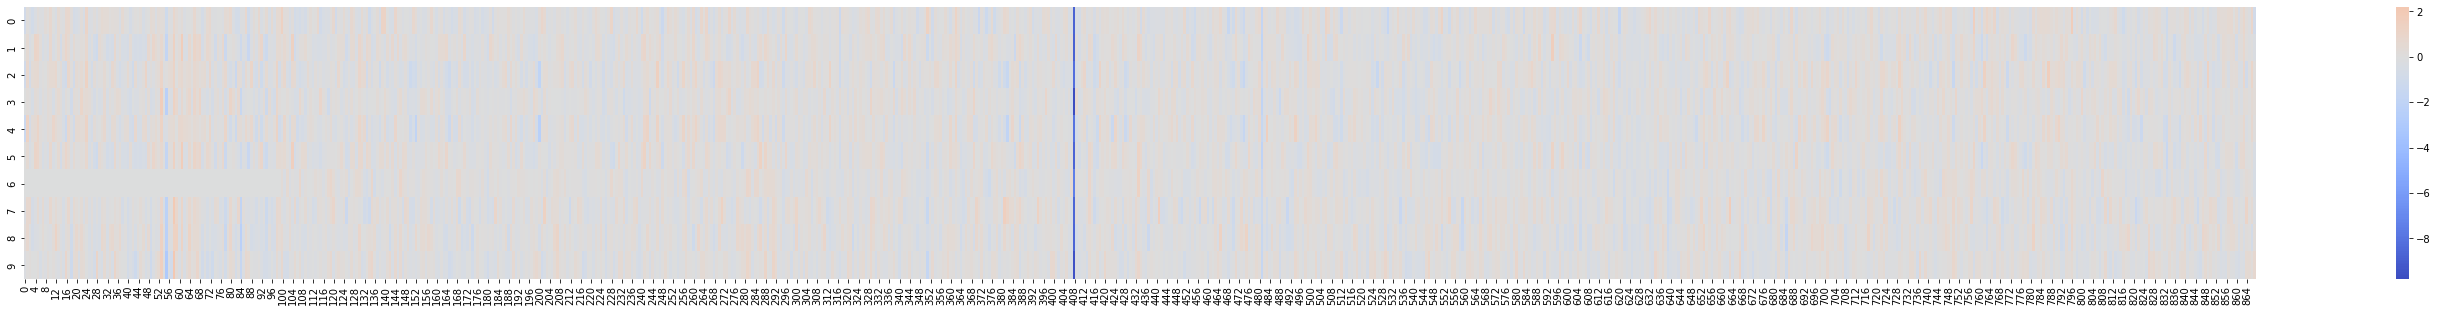

In [209]:
fig, ax = plt.subplots(figsize=(50,5)) 
sns.heatmap(pd.DataFrame(df.embs.loc[1][0:10, :]), cmap="coolwarm", ax=ax, center=0)

# interesting, what is this -10 value
# https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

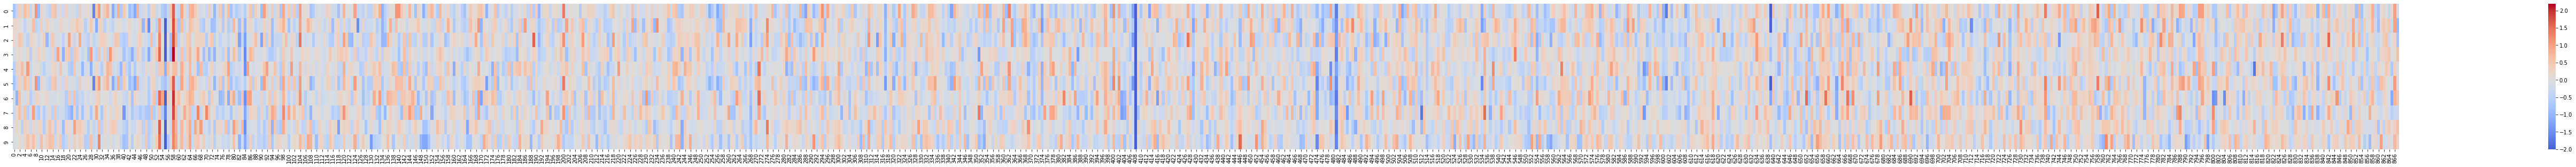

In [82]:
fig, ax = plt.subplots(figsize=(100,5)) 
sns.heatmap(pd.DataFrame(df.embs.loc[1][0:10, :]), cmap="coolwarm", ax=ax, vmin=-2, center=0)

In [83]:
df['state'] = df.apply(lambda x: np.concatenate((x.embs, x.tags), axis=1), axis=1)

In [84]:
df.state.loc[0].shape

(512, 869)

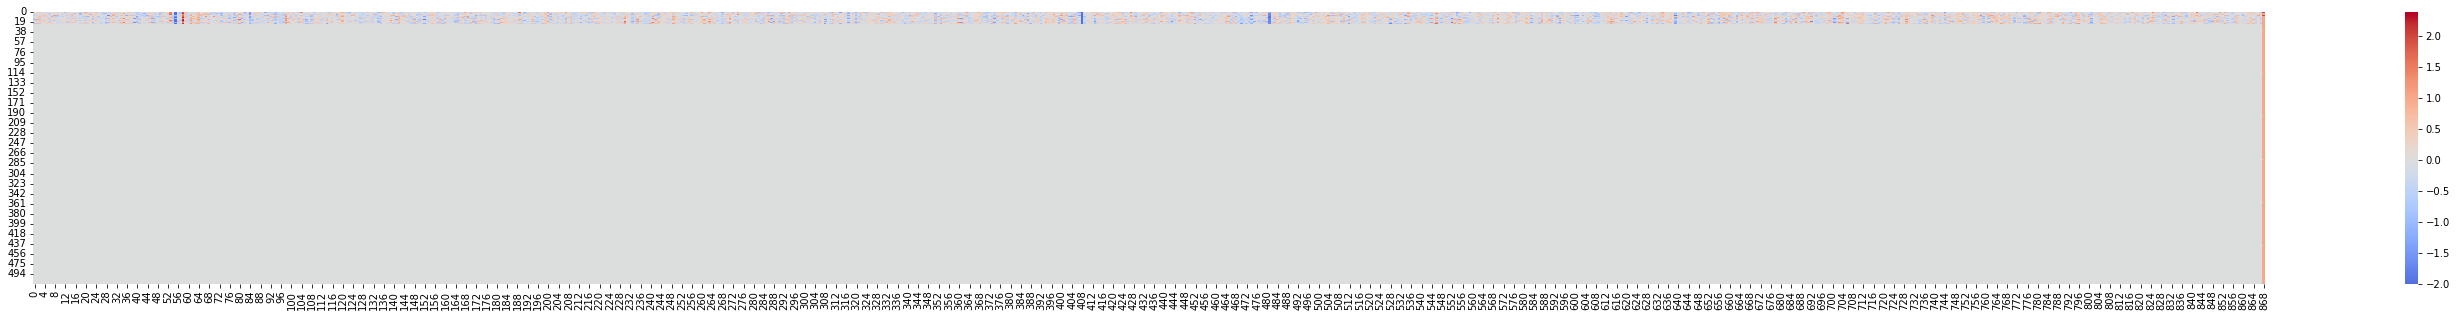

In [85]:
fig, ax = plt.subplots(figsize=(50,5)) 
sns.heatmap(df.state.loc[0], cmap="coolwarm", ax=ax, vmin=-2, center=0)

In [86]:
pd.DataFrame(df.state).to_pickle("win2k_act_states_distilbert_alllayermean_usecontext.pkl")